<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [ ]:
# 바다나우 어텐션
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")

('attention.py', <http.client.HTTPMessage at 0x19ba837d888>)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Bidirectional, TimeDistributed, Flatten
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from konlpy.tag import Mecab
import numpy as np
import os
import urllib
import string
from tqdm.notebook import tqdm
import MeCab
import json
from attention import AttentionLayer

tqdm.pandas()

class Mecab:
    def pos(self, text):
        p = re.compile(".+\t[A-Z]+")
        return [tuple(p.match(line).group().split("\t")) for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
    
    def morphs(self, text):
        p = re.compile(".+\t[A-Z]+")
        return [p.match(line).group().split("\t")[0] for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
    
    def nouns(self, text):
        p = re.compile(".+\t[A-Z]+")
        temp = [tuple(p.match(line).group().split("\t")) for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
        nouns=[]
        for word in temp:
            if word[1] in ["NNG", "NNP", "NNB", "NNBC", "NP", "NR"]:
                nouns.append(word[0])
        return nouns
    
mcb = Mecab()

plt.style.use("dark_background")

C:\Users\5CG7092POZ\Anaconda3\envs\tf2.3\lib\site-packages\tqdm\std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

In [ ]:
train_data = pd.read_table("ratings_train.txt")
test_data = pd.read_table("ratings_test.txt")

train_data["document"] = train_data["document"].str.replace(f"[{string.punctuation}]", " ")
train_data["document"] = train_data["document"].str.replace(r" +", " ")
train_data = train_data[train_data["document"]!=" "]
train_data = train_data.dropna(axis=0)

test_data["document"] = test_data["document"].str.replace(f"[{string.punctuation}]", " ")
test_data["document"] = test_data["document"].str.replace(r" +", " ")
test_data = test_data[test_data["document"]!=" "]
test_data = test_data.dropna(axis=0)

<AxesSubplot:>

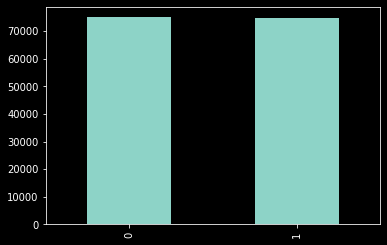

In [ ]:
train_data["label"].value_counts().plot(kind="bar")

In [ ]:
path = "naver_moview_review_train_corp.pkl"
if os.path.exists(path):
    with open(path, "r", encoding="utf-8") as f:
        train_corp = json.load(f)
else:
    train_data["morphs"] = train_data["document"].progress_apply(lambda x:mcb.morphs(x))
    train_corp = train_data["morphs"].tolist()
    with open(path, "w", encoding="utf-8") as f:
        json.dump(train_corp, f, ensure_ascii=False, indent="\t")

path = "naver_moview_review_test_corp.pkl"
if os.path.exists(path):
    with open(path, "r", encoding="utf-8") as f:
        test_corp = json.load(f)
else:
    test_data["morphs"] = test_data["document"].progress_apply(lambda x:mcb.morphs(x))
    test_corp = test_data["morphs"].tolist()
    with open(path, "w", encoding="utf-8") as f:
        json.dump(test_corp, f, ensure_ascii=False, indent="\t")

In [ ]:
X_train = train_corp
X_test = test_corp

tkn = tf.keras.preprocessing.text.Tokenizer()
tkn.fit_on_texts(X_train)

word2idx = tkn.word_index
word2cnt = dict(sorted(tkn.word_counts.items(), key=lambda x:x[1], reverse=True))
cnts = list(word2cnt.values())

ratio = 0.99
for vocab_size, value in enumerate(np.cumsum(cnts)/np.sum(cnts)):
    if value >= ratio:
        break
print(f"{vocab_size:,}개의 단어로 전체 data의 {ratio:.0%}를 표현할 수 있습니다.")
print(f"{len(word2idx):,}개의 단어 중 {vocab_size/len(word2idx):.1%}에 해당합니다.")

28,379개의 단어로 전체 data의 99%를 표현할 수 있습니다.
51,980개의 단어 중 54.6%에 해당합니다.


In [ ]:
tkn = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size+2, oov_token="<UNK>") 
tkn.fit_on_texts(X_train)

word2idx = tkn.word_index
word2cnt = sorted(tkn.word_counts.items(), key=lambda x:x[1], reverse=True)

X_train = tkn.texts_to_sequences(X_train)
X_test = tkn.texts_to_sequences(X_test)

y_train = train_data["label"]
y_test = test_data["label"]

# 빈 샘플들을 제거합니다.
idx_drop = [idx for idx, doc in enumerate(X_train) if len(doc) == 0]

X_train = np.delete(X_train, idx_drop, axis=0)
y_train = np.delete(y_train, idx_drop, axis=0)

In [ ]:
lens = sorted([len(doc) for doc in X_train])
ratio = 0.99
for idx, max_len in enumerate(lens):
    if idx/len(lens) >= ratio:
        break
print(f"가장 긴 문장의 길이는 {np.max(lens)}입니다.")
print(f"길이가 {max_len} 이하인 문장이 전체의 {ratio:.0%}를 차지합니다.")

가장 긴 문장의 길이는 103입니다.
길이가 67 이하인 문장이 전체의 99%를 차지합니다.


In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

t = 어텐션 메커니즘이 수행되는 디코더 셀의 현재 시점을 의미.

Q = Query : t-1 시점의 디코더 셀에서의 은닉 상태
K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
V = Values : 모든 시점의 인코더 셀의 은닉 상태들
- 여기서는 어텐션 함수의 Query가 디코더 셀의 t 시점의 은닉 상태가 아니라 t-1 시점의 은닉 상태임을 주목합시다.
- 1) 어텐션 스코어(Attention Score)를 구한다.
![image.png](attachment:image.png)
- 인코더의 시점(time step)을 각각 1, 2, ... N이라고 하였을 때 인코더의 은닉 상태(hidden state)를 각각 h1, h2, ... hN라고 합시다. 디코더의 현재 시점(time step) t에서의 디코더의 은닉 상태(hidden state)를 st라고 합시다. 또한 여기서는 인코더의 은닉 상태와 디코더의 은닉 상태의 차원이 같다고 가정합니다. 위의 그림의 경우에는 인코더의 은닉 상태와 디코더의 은닉 상태가 동일하게 차원이 4입니다.
- 앞서 루옹 어텐션에서는 Query로 디코더의 t 시점의 은닉 상태를 사용한 것과는 달리 이번에는 t-1 시점의 은닉 상태 st−1를 사용합니다. 바다나우 어텐션의 어텐션 스코어 함수. 즉, st−1과 인코더의 i번째 은닉 상태의 어텐션 스코어 계산 방법은 아래와 같습니다.
$$score(s_{t-1},\ h_{i}) = W_{3}^{T}\ tanh(W_{1}s_{t-1}+W_{2}h_{i})$$
- 단, Wa,Wb,Wc는 학습 가능한 가중치 행렬입니다. 어차피 st−1와 h1,h2,h3,h4의 어텐션 스코어를 각각 구해야하므로 병렬 연산을 위해 h1,h2,h3,h4를 하나의 행렬 H로 두겠습니다. 수식은 다음과 같이 변경됩니다.($W_{b}$와 $W_{c}$는 정사각행렬입니다.)
$$score(s_{t-1},\ H) = W_{a}^{T}\ tanh(W_{b}s_{t-1}+W_{c}H)$$
![image-2.png](attachment:image-2.png)
2) 소프트맥스(softmax) 함수를 통해 어텐션 분포(Attention Distribution)를 구한다.
![image-3.png](attachment:image-3.png)
![image-6.png](attachment:image-6.png)
- 이제 지금까지 준비해온 정보들을 하나로 합치는 단계입니다. 어텐션의 최종 결과값을 얻기 위해서 각 인코더의 은닉 상태와 어텐션 가중치값들을 곱하고, 최종적으로 모두 더합니다. 요약하면 가중합(Weighted Sum)을 한다고 말할 수도 있겠습니다. 이 벡터는 인코더의 문맥을 포함하고 있다고하여, 컨텍스트 벡터(context vector)라고 부릅니다.
![image-4.png](attachment:image-4.png)
- 기존의 LSTM이 st를 구할 때를 아래 그림을 통해 상기해봅시다. 기존의 LSTM은 이전 시점의 셀로부터 전달받은 은닉 상태 st−1와 현재 시점의 입력 xt를 가지고 연산하였습니다. 아래의 LSTM은 seq2seq의 디코더이며 현재 시점의 입력 xt는 임베딩된 단어 벡터입니다.
![image-5.png](attachment:image-5.png)
- 그렇다면 어텐션 메커니즘에서는 어떨까요? 아래의 그림은 바다나우 어텐션 메커니즘에서는 컨텍스트 벡터와 현재 시점의 입력인 단어의 임베딩 벡터를 연결(concatenate)하고, 현재 시점의 새로운 입력으로 사용하는 모습을 보여줍니다. 그리고 이전 시점의 셀로부터 전달받은 은닉 상태 st−1와 현재 시점의 새로운 입력으로부터 st를 구합니다.
- 다시 말해 기존의 LSTM이 임베딩된 단어 벡터를 입력으로 하는 것에서 컨텍스트 벡터와 임베딩된 단어 벡터를 연결(concatenate)하여 입력으로 사용하는 것이 달라졌습니다.

In [ ]:
class Bahdanau(tf.keras.Model):
    def __init__(self, units):
        super().__init__()
        self.W1 = Dense(units, use_bias=False)
        self.W2 = Dense(units, use_bias=False)
        self.W3 = Dense(1)
        
        # key와 value는 같습니다.
    def call(self, query, keys):
        # query.shape : (batch_size, h_size) --> (batch_size, 1, h_size)
        query = tf.expand_dims(query, axis=1)

        # att_scores.shape : (batch_size, max_len, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.W3 : (batch_size, max_len, units)
        att_scores = self.W3(tf.nn.tanh(self.W1(query) + self.W2(keys)))

        # att_weights.shape : (batch_size, max_len, 1)
        att_weights = tf.nn.softmax(att_scores, axis=1)

        # context_vector.shape : (batch_size, h_size)
        context_vector = att_weights*keys
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, att_weights

- 이제 양방향 LSTM을 설계합니다. 단, 여기서는 양방향 LSTM을 두 층을 사용하겠습니다. 우선, 첫번째 층입니다. 두번째 층을 위에 쌓을 예정이므로 return_sequences를 True로 해주어야 합니다.

In [ ]:
model_path = "naver_movie_review_BiLSTM_Bahdanau.h5"
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    
    model.summary()
    
    with open(f"{model_path}_hist", "r") as f:
        hist.history = json.load(f)
else:
    z1 = tf.keras.Input(shape=(max_len,), dtype="int32", name="z1")
    z2 = Embedding(input_dim=vocab_size+2, output_dim=128, mask_zero=True, name="z2")(z1)
    h_size = 64
    z3 = Bidirectional(LSTM(units=h_size, return_sequences=True), name="z3")(z2)
    z4, for_h_state, for_c_state, back_h_state, back_c_state = Bidirectional(LSTM(units=h_size, return_sequences=True, return_state=True), name="z4")(z3)

    # 양방향 LSTM을 사용할 경우에는 순방향 LSTM과 역방향 LSTM 각각 은닉 상태와 셀 상태를 가지므로, 양방향 LSTM의 은닉 상태와 셀 상태를 사용하려면 두 방향의 LSTM의 상태들을 연결(concatenate)해주면 됩니다.
    h_state = Concatenate(name="h_state")([for_h_state, back_h_state])

    context_vector, _ = Bahdanau(units=h_size)(query=h_state, keys=z4)
#     context_vector, _ = AttentionLayer()([h_state, z4])
#     context_vector, _ = AttentionLayer()([z4, h_state])
#     context_vector, _ = tf.keras.layers.Attention()([h_state, z4])
    
    z5 = Dense(units=20, activation="relu", name="z5")(context_vector)
    z6 = Dense(units=1, activation="sigmoid", name="z6")(z5)

    model = tf.keras.Model(inputs=z1, outputs=z6)

    model.summary()
    
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["binary_accuracy"])

    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", verbose=1, patience=2)
    mc = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor="val_binary_accuracy", mode="auto", verbose=1, save_best_only=True)

    hist = model.fit(x=X_train, y=y_train, validation_split=0.2, batch_size=256, epochs=8, verbose=1, callbacks=[es, mc])
    
    with open(f"{model_path}_hist", "w") as f:
        json.dump(hist.history, f)

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z1 (InputLayer)                 [(None, 67)]         0                                            
__________________________________________________________________________________________________
z2 (Embedding)                  (None, 67, 128)      3632768     z1[0][0]                         
__________________________________________________________________________________________________
z3 (Bidirectional)              (None, 67, 128)      98816       z2[0][0]                         
__________________________________________________________________________________________________
z4 (Bidirectional)              [(None, 67, 128), (N 98816       z3[0][0]                         
______________________________________________________________________________________

In [ ]:
hist.history

NameError: name 'hist' is not defined

In [ ]:
with open(f"{model_path}_hist", "w") as f:
    json.dump(hist.history, f)

NameError: name 'hist' is not defined

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

48995/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================